In [1]:
################################################################
##
## Copyright 2017 Sandia Corporation. Under the terms of
## Contract DE-AC04-94AL85000 with Sandia Corporation, the
## U.S. Government retains certain rights in this software.
## This software is distributed under the BSD-3-Clause license.
##
###############################################################
#
import numpy as np
import matplotlib.pyplot as plt
#
from turbulencekepspreprocessor import TurbulenceKEpsDataProcessor
from tbnn import NetworkStructure, TBNN
#
#"""
#In this example, a Tensor Basis Neural Network (TBNN) is trained on the data for a simple turbulent channel flow.
#The inputs are the mean strain rate tensor and the mean rotation rate tensor (normalized by k and epsilon).
#The output is the Reynolds stress anisotropy tensor.
#
#Data:
#The channel data set is based on a profile from the channel flow DNS of Moser et al. at Re_tau=590.
#The tke, epsilon, and velocity gradient are from a k-epsilon RANS of the same flow.
#The Reynolds stresses are from the DNS.
#
#Reference for DNS data: Moser, R. D., Kim, J., & Mansour, N. N. (1999).
#"Direct numerical simulation of turbulent channel flow up to Re= 590". Phys. Fluids, 11(4), 943-945.
#
#Reference for data driven turbulence modeling TBNN implementation:
#Ling, J., Kurzawski, A. and Templeton, J., 2016. Reynolds averaged turbulence modelling using deep neural
#networks with embedded invariance. Journal of Fluid Mechanics, 807, pp.155-166.
#"""
#
#
def load_channel_data():
    """
    Loads in channel flow data
    :return:
    """

    # Load in data from channel.txt
    data = np.loadtxt('../data/channel.txt', skiprows=4)
    k = data[:, 0]
    eps = data[:, 1]
    grad_u_flat = data[:, 2:11]
    stresses_flat = data[:, 11:]

    # Reshape grad_u and stresses to num_points X 3 X 3 arrays
    num_points = data.shape[0]
    grad_u = np.zeros((num_points, 3, 3))
    stresses = np.zeros((num_points, 3, 3))
    for i in xrange(3):
        for j in xrange(3):
            grad_u[:, i, j] = grad_u_flat[:, i*3+j]
            stresses[:, i, j] = stresses_flat[:, i*3+j]
    return k, eps, grad_u, stresses


def plot_results(predicted_stresses, true_stresses,dire):
    """
    Create a plot with 9 subplots.  Each subplot shows the predicted vs the true value of that
    stress anisotropy component.  Correct predictions should lie on the y=x line (shown with
    red dash).
    :param predicted_stresses: Predicted Reynolds stress anisotropy (from TBNN predictions)
    :param true_stresses: True Reynolds stress anisotropy (from DNS)
    """
    fig = plt.figure(figsize=(8,8))
    fig.patch.set_facecolor('white')
    on_diag = [0, 4, 8]
    for i in xrange(9):
            plt.subplot(3, 3, i+1)
            ax = fig.gca()
            ax.set_aspect('equal')
            plt.plot([-1., 1.], [-1., 1.], 'r--')
            plt.scatter(true_stresses[:, i], predicted_stresses[:, i])
            plt.xlabel('True value')
            plt.ylabel('Predicted value')
            idx_1 = i / 3
            idx_2 = i % 3
            plt.title('A' + str(idx_1) + str(idx_2))
            if i in on_diag:
                plt.xlim([-2./3., 2./3.])
                plt.ylim([-2./3., 2./3.])
            else:
                plt.xlim([-1.5, 1.5])
                plt.ylim([-1.5, 1.5])
    plt.tight_layout()
    plt.savefig(dire, dpi=360)
    plt.show()


Re-setting normalization constants
Epoch time training_loss validation_loss
     1  0.0282   0.04640959   0.04141327
   101  0.0239   0.02282352   0.01442264
   201  0.0357   0.02830217   0.01979970
   301  0.0241   0.02318136   0.01627961
   401  0.0242   0.02240728   0.01787891
   501  0.0338   0.02281485   0.01940179
   601  0.0247   0.02251361   0.01872710
   701  0.0240   0.04270050   0.04495008
   801  0.0240   0.03957327   0.03592122
   901  0.0240   0.03409407   0.03078028
  1001  0.0241   0.02221343   0.02101254
Total number of epochs:  1001
Final rmse validation error:  0.021012538383462


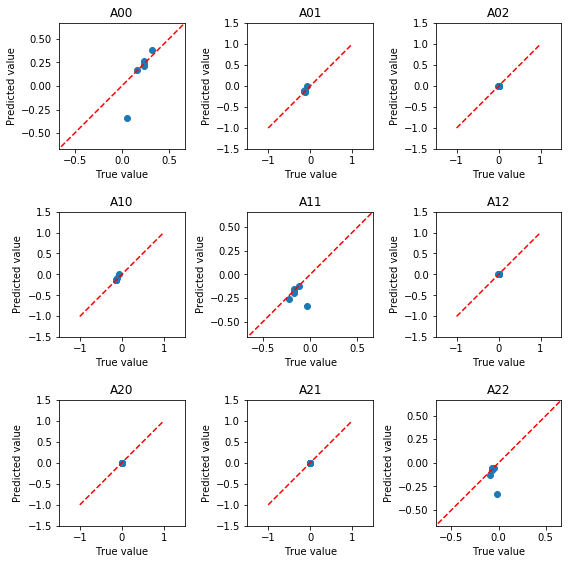

RMSE on training data: 0.022080757433864083
RMSE on test data: 0.08138034478672197


In [2]:
# Define parameters:
num_layers = 5  # Number of hidden layers in the TBNN
num_nodes = 25  # Number of nodes per hidden layer
max_epochs = 5000  # Max number of epochs during training
min_epochs = 1000  # Min number of training epochs required
interval = 100  # Frequency at which convergence is checked
average_interval = 4  # Number of intervals averaged over for early stopping criteria
split_fraction = 0.9  # Fraction of data to use for training
enforce_realizability = True  # Whether or not we want to enforce realizability constraint on Reynolds stresses
num_realizability_its = 5  # Number of iterations to enforce realizability
seed = 12345 # use for reproducibility, set equal to None for no seeding

# Load in data
k, eps, grad_u, stresses = load_channel_data()

# Calculate inputs and outputs
data_processor = TurbulenceKEpsDataProcessor()
Sij, Rij = data_processor.calc_Sij_Rij(grad_u, k, eps)
x = data_processor.calc_scalar_basis(Sij, Rij, is_train=True)  # Scalar basis
tb = data_processor.calc_tensor_basis(Sij, Rij, quadratic_only=False)  # Tensor basis
y = data_processor.calc_output(stresses)  # Anisotropy tensor

# Enforce realizability
if enforce_realizability:
    for i in range(num_realizability_its):
        y = TurbulenceKEpsDataProcessor.make_realizable(y)

# Split into training and test data sets
if seed:
    np.random.seed(seed) # sets the random seed for Theano
x_train, tb_train, y_train, x_test, tb_test, y_test = \
    TurbulenceKEpsDataProcessor.train_test_split(x, tb, y, fraction=split_fraction, seed=seed)

# Define network structure
structure = NetworkStructure()
structure.set_num_layers(num_layers)
structure.set_num_nodes(num_nodes)

# Initialize and fit TBNN
tbnn = TBNN(structure)
tbnn.fit(x_train, tb_train, y_train, max_epochs=max_epochs, min_epochs=min_epochs, interval=interval, average_interval=average_interval)

# Make predictions on train and test data to get train error and test error
labels_train = tbnn.predict(x_train, tb_train)
labels_test = tbnn.predict(x_test, tb_test)

# Enforce realizability
if enforce_realizability:
    for i in range(num_realizability_its):
        labels_train = TurbulenceKEpsDataProcessor.make_realizable(labels_train)
        labels_test = TurbulenceKEpsDataProcessor.make_realizable(labels_test)

# Determine error
rmse_train = tbnn.rmse_score(y_train, labels_train )

# Plot the results
dire ='../results/results_1.png'
plot_results(y_test, labels_test,dire)
rmse_test = tbnn.rmse_score(y_test, labels_test)
print "RMSE on training data:", rmse_train
print "RMSE on test data:", rmse_test

Re-setting normalization constants
Epoch time training_loss validation_loss
     1  0.0153   0.05867989   0.07604557
   101  0.0145   0.02609436   0.01870670
   201  0.0147   0.02263088   0.00900227
   301  0.0146   0.02180856   0.01006008
   401  0.0146   0.02997435   0.01705307
   501  0.0145   0.02233185   0.01141928
   601  0.0156   0.02220470   0.00899515
   701  0.0167   0.02059797   0.00762632
   801  0.0166   0.02965135   0.01107397
   901  0.0175   0.02033484   0.01028033
  1001  0.0229   0.02093847   0.01460230
  1101  0.0146   0.01979644   0.00621958
  1201  0.0146   0.02005646   0.00746267
Total number of epochs:  1201
Final rmse validation error:  0.007462667497227727


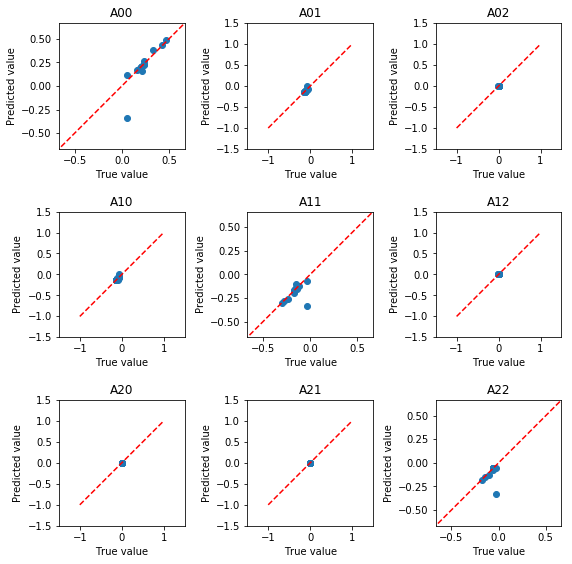

RMSE on training data: 0.01904716813431485
RMSE on test data: 0.052372867399503545


In [3]:
# Define parameters:
num_layers = 3  # Number of hidden layers in the TBNN
num_nodes = 20  # Number of nodes per hidden layer
max_epochs = 3000  # Max number of epochs during training
min_epochs = 1000  # Min number of training epochs required
interval = 100  # Frequency at which convergence is checked
average_interval = 4  # Number of intervals averaged over for early stopping criteria
split_fraction = 0.75  # Fraction of data to use for training
enforce_realizability = True  # Whether or not we want to enforce realizability constraint on Reynolds stresses
num_realizability_its = 5  # Number of iterations to enforce realizability
seed = 12345 # use for reproducibility, set equal to None for no seeding

# Load in data
k, eps, grad_u, stresses = load_channel_data()

# Calculate inputs and outputs
data_processor = TurbulenceKEpsDataProcessor()
Sij, Rij = data_processor.calc_Sij_Rij(grad_u, k, eps)
x = data_processor.calc_scalar_basis(Sij, Rij, is_train=True)  # Scalar basis
tb = data_processor.calc_tensor_basis(Sij, Rij, quadratic_only=False)  # Tensor basis
y = data_processor.calc_output(stresses)  # Anisotropy tensor

# Enforce realizability
if enforce_realizability:
    for i in range(num_realizability_its):
        y = TurbulenceKEpsDataProcessor.make_realizable(y)

# Split into training and test data sets
if seed:
    np.random.seed(seed) # sets the random seed for Theano
x_train, tb_train, y_train, x_test, tb_test, y_test = \
    TurbulenceKEpsDataProcessor.train_test_split(x, tb, y, fraction=split_fraction, seed=seed)

# Define network structure
structure = NetworkStructure()
structure.set_num_layers(num_layers)
structure.set_num_nodes(num_nodes)

# Initialize and fit TBNN
tbnn = TBNN(structure)
tbnn.fit(x_train, tb_train, y_train, max_epochs=max_epochs, min_epochs=min_epochs, interval=interval, average_interval=average_interval)

# Make predictions on train and test data to get train error and test error
labels_train = tbnn.predict(x_train, tb_train)
labels_test = tbnn.predict(x_test, tb_test)

# Enforce realizability
if enforce_realizability:
    for i in range(num_realizability_its):
        labels_train = TurbulenceKEpsDataProcessor.make_realizable(labels_train)
        labels_test = TurbulenceKEpsDataProcessor.make_realizable(labels_test)

# Determine error
rmse_train = tbnn.rmse_score(y_train, labels_train )

# Plot the results
dire ='../results/results_2.png'
plot_results(y_test, labels_test,dire)
rmse_test = tbnn.rmse_score(y_test, labels_test)
print "RMSE on training data:", rmse_train
print "RMSE on test data:", rmse_test

Re-setting normalization constants
Epoch time training_loss validation_loss
     1  0.0084   0.07593821   0.05231300
   101  0.0074   0.02830147   0.03137628
   201  0.0064   0.02736144   0.03493010
   301  0.0064   0.02841748   0.03931664
   401  0.0064   0.02533434   0.03714344
   501  0.0064   0.02609387   0.03676131
   601  0.0064   0.02447672   0.04010230
   701  0.0064   0.02666663   0.03321404
   801  0.0064   0.02283938   0.03567831
   901  0.0073   0.02287228   0.03657200
  1001  0.0074   0.02307467   0.03538239
  1101  0.0074   0.02506068   0.03220009
  1201  0.0074   0.02276285   0.03778305
  1301  0.0074   0.02228340   0.03596774
  1401  0.0065   0.02183949   0.03560528
Total number of epochs:  1401
Final rmse validation error:  0.03560527766835726


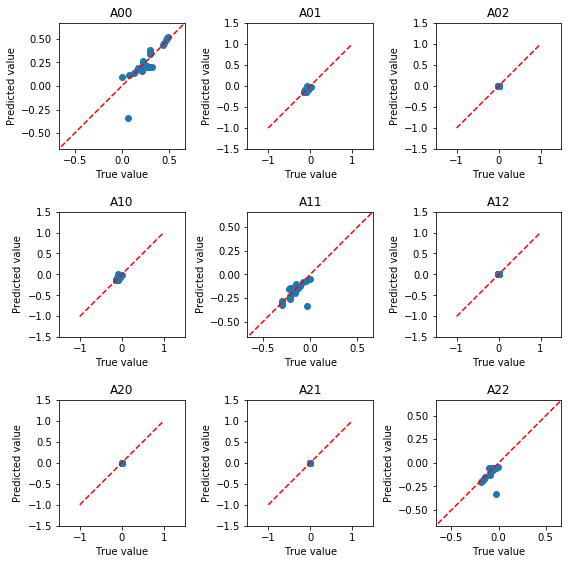

RMSE on training data: 0.023638261599496148
RMSE on test data: 0.04246704942774677


In [4]:
# Define parameters:
num_layers = 1  # Number of hidden layers in the TBNN
num_nodes = 30  # Number of nodes per hidden layer
max_epochs = 2000  # Max number of epochs during training
min_epochs = 1000  # Min number of training epochs required
interval = 100  # Frequency at which convergence is checked
average_interval = 4  # Number of intervals averaged over for early stopping criteria
split_fraction = 0.5  # Fraction of data to use for training
enforce_realizability = True  # Whether or not we want to enforce realizability constraint on Reynolds stresses
num_realizability_its = 5  # Number of iterations to enforce realizability
seed = 12345 # use for reproducibility, set equal to None for no seeding

# Load in data
k, eps, grad_u, stresses = load_channel_data()

# Calculate inputs and outputs
data_processor = TurbulenceKEpsDataProcessor()
Sij, Rij = data_processor.calc_Sij_Rij(grad_u, k, eps)
x = data_processor.calc_scalar_basis(Sij, Rij, is_train=True)  # Scalar basis
tb = data_processor.calc_tensor_basis(Sij, Rij, quadratic_only=False)  # Tensor basis
y = data_processor.calc_output(stresses)  # Anisotropy tensor

# Enforce realizability
if enforce_realizability:
    for i in range(num_realizability_its):
        y = TurbulenceKEpsDataProcessor.make_realizable(y)

# Split into training and test data sets
if seed:
    np.random.seed(seed) # sets the random seed for Theano
x_train, tb_train, y_train, x_test, tb_test, y_test = \
    TurbulenceKEpsDataProcessor.train_test_split(x, tb, y, fraction=split_fraction, seed=seed)

# Define network structure
structure = NetworkStructure()
structure.set_num_layers(num_layers)
structure.set_num_nodes(num_nodes)

# Initialize and fit TBNN
tbnn = TBNN(structure)
tbnn.fit(x_train, tb_train, y_train, max_epochs=max_epochs, min_epochs=min_epochs, interval=interval, average_interval=average_interval)

# Make predictions on train and test data to get train error and test error
labels_train = tbnn.predict(x_train, tb_train)
labels_test = tbnn.predict(x_test, tb_test)

# Enforce realizability
if enforce_realizability:
    for i in range(num_realizability_its):
        labels_train = TurbulenceKEpsDataProcessor.make_realizable(labels_train)
        labels_test = TurbulenceKEpsDataProcessor.make_realizable(labels_test)

# Determine error
rmse_train = tbnn.rmse_score(y_train, labels_train )

# Plot the results
dire ='../results/results_3.png'
plot_results(y_test, labels_test,dire)
rmse_test = tbnn.rmse_score(y_test, labels_test)
print "RMSE on training data:", rmse_train
print "RMSE on test data:", rmse_test